In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA

In [3]:
!pip install efficientnet

     |████████████████████████████████| 51kB 4.6MB/s 


In [4]:
import keras 
from keras import applications, metrics, layers, models, regularizers, optimizers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB4

In [5]:
'''try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()'''

'try:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nexcept ValueError:\n    print("Not connected to a TPU runtime. Using CPU/GPU strategy")\n    strategy = tf.distribute.MirroredStrategy()'

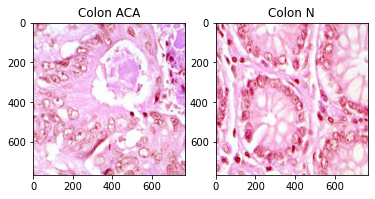

In [6]:
colon_aca =  "/content/drive/MyDrive/Colon_Dataset_100/colon_aca_50/"

plt.subplot(121)
img = cv2.imread(colon_aca + os.listdir(colon_aca)[0])
plt.title('Colon ACA')
plt.imshow(img)

plt.subplot(122)
colon_n = "/content/drive/MyDrive/Colon_Dataset_100/colon_n_50/"
img = cv2.imread(colon_n + os.listdir(colon_n)[0])
plt.title('Colon N')
plt.imshow(img)
plt.show()

In [7]:
data_dir = "/content/drive/MyDrive/Colon_Dataset_100/"
SIZE_X = SIZE_Y = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.1)

train_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 5, 
                                       shuffle = True,
                                       subset='training',
                                       seed = 42)

validate_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 4, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 90 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [8]:

def get_features(base_model, train, validate):
    X_train = base_model.predict(train)
    y_train = train.classes

    X_val = base_model.predict(validate)
    y_val = validate.classes

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.1, shuffle = True)
    print('Shape of X_train----->', str(X_train.shape))
    print('Shape of X_val----->', str(X_val.shape))
    print('Shape of X_test----->', str(X_test.shape))
    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [9]:

def get_models():
    ANN = Sequential()
    ANN.add(Dense(128, input_dim = X_train.shape[1], activation = 'relu'))
    ANN.add(BatchNormalization())
    ANN.add(Dropout(0.2))
    ANN.add(Dense(64, activation='relu'))
    ANN.add(Dense(32, activation='relu'))
    ANN.add(Dense(16, activation='relu'))
    ANN.add(Dense(8, activation='relu'))
    ANN.add(Dense(len(train_it.class_indices), activation='softmax'))
    ANN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    KNN = KNeighborsClassifier()
    
    SVM = SVC(kernel = 'linear')
    
    RF = RandomForestClassifier(n_estimators = 50)
    
    ADB = AdaBoostClassifier()
    
    XGB = XGBClassifier(n_estimators = 50, use_label_encoder=False)
    
    print("Defined------->")
    print("ANN -------->", "(128x64x32x16x8)")
    print("KNeighborsClassifier()")
    print("SVC(kernel = 'linear')")
    print("RandomForestClassifier(n_estimators = 50)")
    print("AdaBoostClassifier()")
    print("XGBClassifier(n_estimators = 50)")
    
    return (ANN, KNN, SVM, RF, ADB, XGB)

In [10]:
def reshape_data(X_train, X_val, X_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Shape after reshaping------->")
    print("X train------->", str(X_train.shape))
    print("X val-------->", str(X_val.shape))
    print("X test-------->", str(X_test.shape))
    
    return (X_train, X_val, X_test)

In [11]:
def fit_ANN(model, X_train, y_train, X_val, y_test):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_test), epochs=10, verbose=1, callbacks=[es])
    return model

def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def get_accuracy_metrics_for_ANN(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, np.argmax(model.predict(X_train), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = np.argmax(model.predict(X_val), axis = 1)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  np.argmax(model.predict(X_test), axis = 1)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [12]:
def fit_KNN_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    pca = PCA(n_components=10)
    randlist = random.sample(range(0, X_train.shape[0]), 10)
    if(X_train.shape[1] > 10):
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)

    model.fit(X_train, y_train)
    get_accuracy_metrics(model, X_train[randlist, :], y_train[randlist], X_val, y_val, X_test, y_test)
    
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, model.predict(X_train))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = model.predict(X_val)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  model.predict(X_test)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [13]:

'''base_model = EfficientNetB4(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
                   
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
model.summary() '''

"base_model = EfficientNetB4(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')\n\nfor layer in base_model.layers:\n    layer.trainable = False\n                   \nmodel = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)\nmodel.summary() "

In [14]:
# X_train, X_val, X_test, y_train, y_val, y_test = get_features(model, train_it, validate_it)

In [15]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [16]:
 from tensorflow.keras.applications import EfficientNetB0
IMG_SIZE = 224

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
outputs = EfficientNetB0(include_top=True, weights=None, classes=2)(x)
model = tf.keras.Model(inputs, outputs)
model.compile( optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 2)                 4052133   
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [24]:
'''epochs = 10  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_it, epochs=epochs, validation_data=validate_it, verbose=2,)'''

'epochs = 10  # @param {type: "slider", min:10, max:100}\nhist = model.fit(train_it, epochs=epochs, validation_data=validate_it, verbose=2,)'

In [25]:
X_train, X_val, X_test, y_train, y_val, y_test = get_features(model, train_it, validate_it)

Shape of X_train-----> (90, 2)
Shape of X_val-----> (9, 2)
Shape of X_test-----> (1, 2)


In [26]:
X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
ANN, KNN, SVM, RF, ADB, XGB = get_models()

ANN = fit_ANN(ANN, X_train, y_train, X_val, y_val)

Shape after reshaping------->
X train-------> (90, 2)
X val--------> (9, 2)
X test--------> (1, 2)
Defined------->
ANN --------> (128x64x32x16x8)
KNeighborsClassifier()
SVC(kernel = 'linear')
RandomForestClassifier(n_estimators = 50)
AdaBoostClassifier()
XGBClassifier(n_estimators = 50)
Epoch 1/10
3/3 [==============================] - 1s 91ms/step - loss: 0.6934 - accuracy: 0.4556 - val_loss: 0.6924 - val_accuracy: 0.5556
Epoch 2/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5556
Epoch 3/10
3/3 [==============================] - 0s 20ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5556
Epoch 4/10
3/3 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5556
Epoch 5/10
3/3 [==============================] - 0s 19ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5556
Epoch 6/10
3/3 [=

Train accuracy Score------------>
50.000 %
Val accuracy Score--------->
55.556 %
Test accuracy Score--------->
0.000 %
F1 Score--------------->
0.000 %
Cohen Kappa Score------------->
0.000 %
Recall-------------->
0.000 %
Precision-------------->
0.000 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


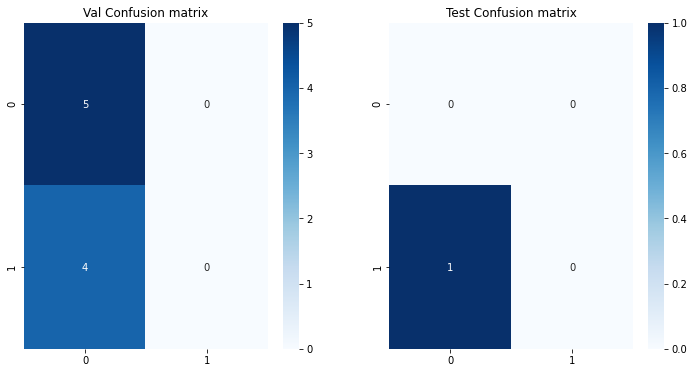

In [27]:
get_accuracy_metrics_for_ANN(ANN, X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
60.000 %
Val accuracy Score--------->
22.222 %
Test accuracy Score--------->
100.000 %
F1 Score--------------->
100.000 %
Cohen Kappa Score------------->
nan %
Recall-------------->
100.000 %
Precision-------------->
100.000 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


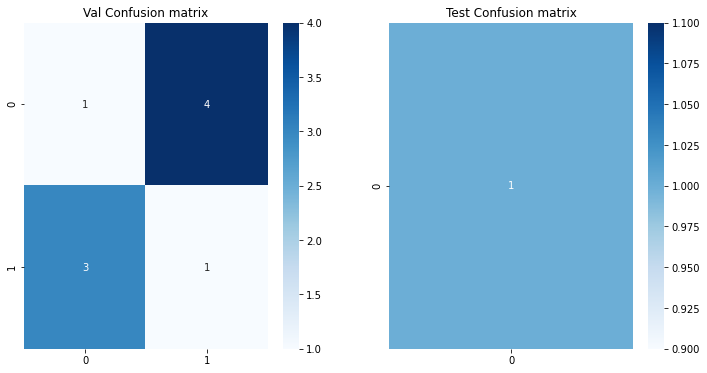

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

fit_KNN_metrics(KNN, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
53.333 %
Val accuracy Score--------->
55.556 %
Test accuracy Score--------->
100.000 %
F1 Score--------------->
100.000 %
Cohen Kappa Score------------->
nan %
Recall-------------->
100.000 %
Precision-------------->
100.000 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


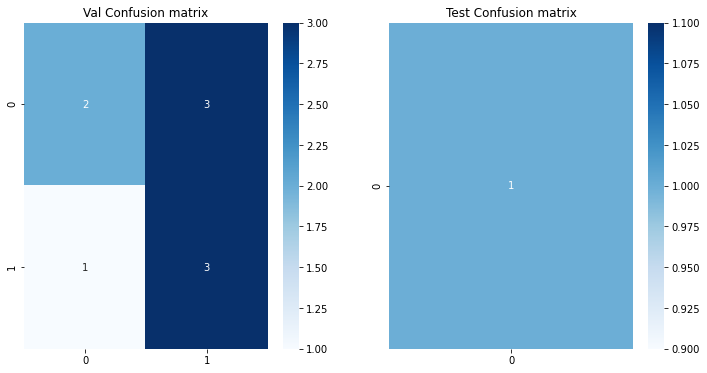

In [29]:
SVM = fit_model(SVM, X_train_scaled, y_train)
get_accuracy_metrics(SVM, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
88.889 %
Val accuracy Score--------->
33.333 %
Test accuracy Score--------->
100.000 %
F1 Score--------------->
100.000 %
Cohen Kappa Score------------->
nan %
Recall-------------->
100.000 %
Precision-------------->
100.000 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


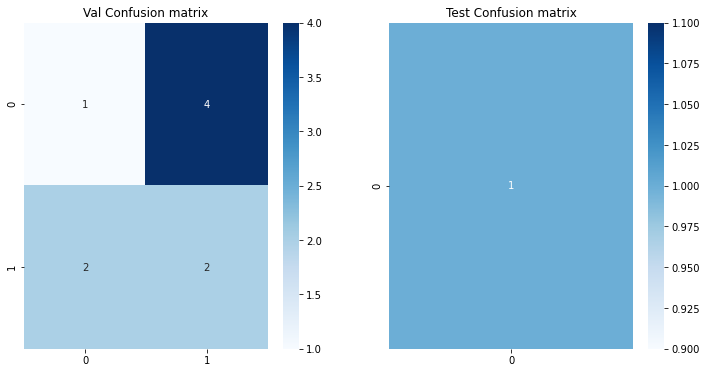

In [30]:
RF = fit_model(RF, X_train, y_train)
get_accuracy_metrics(RF,  X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
86.667 %
Val accuracy Score--------->
33.333 %
Test accuracy Score--------->
100.000 %
F1 Score--------------->
100.000 %
Cohen Kappa Score------------->
nan %
Recall-------------->
100.000 %
Precision-------------->
100.000 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


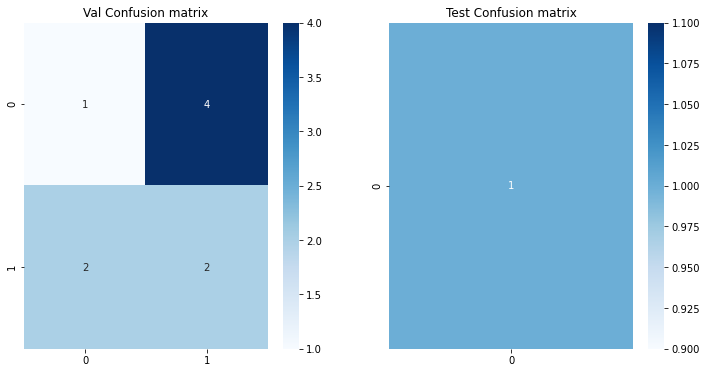

In [31]:
ADB = fit_model(ADB, X_train, y_train)
get_accuracy_metrics(ADB,  X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
77.778 %
Val accuracy Score--------->
22.222 %
Test accuracy Score--------->
100.000 %
F1 Score--------------->
100.000 %
Cohen Kappa Score------------->
nan %
Recall-------------->
100.000 %
Precision-------------->
100.000 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


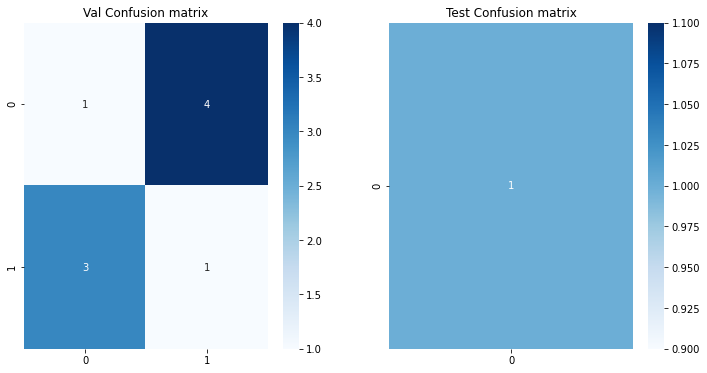

In [32]:
XGB = fit_model(XGB, X_train, y_train)
get_accuracy_metrics(XGB,  X_train, y_train, X_val, y_val, X_test, y_test)